In [2]:
using DelimitedFiles
using MultivariateStats
using HDF5
using Plots; gr();

using GaussianMixtures
using Distributions

using StatGeochem

In [3]:
ign, h = readdlm("../data/remote/base_nobin/bsr_ignmajors_1.csv", ',', header=true)
ign = ign[:,2:11]
h = h[2:11];

In [4]:
cnorm = fill(NaN, size(ign))

for c in 1:size(ign)[2]
    cnorm[:,c] .= (ign[:,c] .- nanmean(ign[:,c]))./nanstd(ign[:,c])
end

cpca = fit(PCA, cnorm')
principalvars(cpca)./tprincipalvar(cpca)

9-element Array{Float64,1}:
 0.40559020843448346
 0.1551400225733932
 0.10197590363358515
 0.09904523974892955
 0.08181719173200362
 0.06813958628752298
 0.03444233354004996
 0.03416680380013322
 0.019682710249898615

In [5]:
ctrans = transform(cpca, cnorm');

In [6]:
x = Vector(ctrans[1,:])

gm = GMM(2, x)
m = MixtureModel(gm)

┌ Info: Initializing GMM, 2 Gaussians diag covariance 1 dimensions using 100000 data points
└ @ GaussianMixtures /Users/gailin/.julia/packages/GaussianMixtures/1pQcF/src/train.jl:79


K-means converged with 7 iterations (objv = 1726.1732076681922)


┌ Info: K-means with 2000 data points using 7 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures /Users/gailin/.julia/packages/GaussianMixtures/1pQcF/src/train.jl:140


MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.4378): Normal{Float64}(μ=-1.9847266433776665, σ=0.768087962903391)
components[2] (prior = 0.5622): Normal{Float64}(μ=1.5454359432368414, σ=1.139735114202038)


In [ ]:
typeof(m)

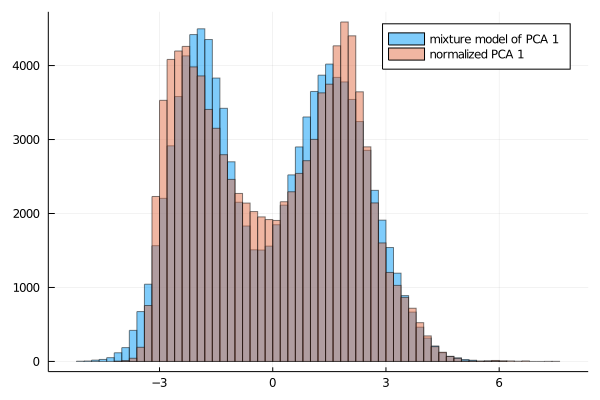

In [52]:
histogram(rand(m,100000), alpha=0.5, label="mixture model of PCA 1")
histogram!(ctrans[1,:], alpha=0.5, label="normalized PCA 1")

In [43]:
pdf(m, [-2,0,2])

3-element Array{Float64,1}:
 0.22708264403215944
 0.08412751012791146
 0.18357983968441757

# Now try in all dimensions

Works PRETTY GREAT. Doesn't converge when using all samples. Some weird effects around 0 because the real data exists in compositional space and the gaussians don't. 

In [99]:
dset = ign # cnorm or ign or ctrans'
n = 1000 # does not converge for all 100000 samples

gmw = GMM(11, Matrix(dset[rand(1:size(dset)[1],n),:]))
mw = MixtureModel(gmw);

K-means converged with 27 iterations (objv = 24864.916870940226)


┌ Info: Initializing GMM, 11 Gaussians diag covariance 10 dimensions using 1000 data points
└ @ GaussianMixtures /Users/gailin/.julia/packages/GaussianMixtures/1pQcF/src/train.jl:79
┌ Info: K-means with 1000 data points using 27 iterations
│ 8.3 data points per parameter
└ @ GaussianMixtures /Users/gailin/.julia/packages/GaussianMixtures/1pQcF/src/train.jl:140


In [100]:
rand(mw, 2)

10×2 Array{Float64,2}:
 57.2227    69.5049
  0.472026   0.417069
 15.5944    12.8441
  4.96194    1.09096
  1.78298    0.48888
  5.31497    3.25692
  3.46696    4.57502
  4.33442    0.706958
  1.31175   -0.315371
  0.760047   2.44691

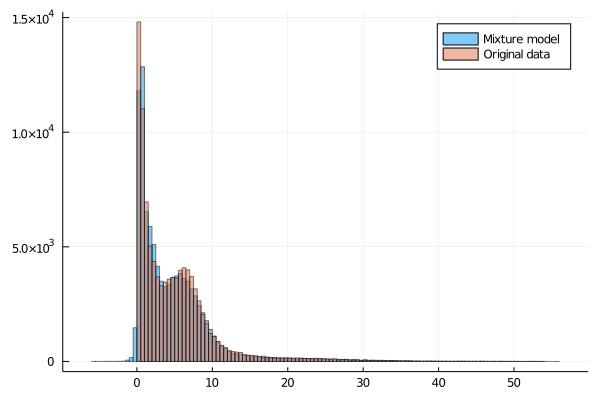

In [103]:
elt = 5
histogram(rand(mw,100000)[elt,:], alpha=0.5, label="Mixture model")
histogram!(dset[:,elt], alpha=0.5, label="Original data")

# Now try with logratio transform

In [215]:
"""
    transform(A)
Each row of A is a sample, each column a variable. First row must be non-zero. 
Turn rows 2:end into ratios of row 1, then take log. 
"""
function logratio(A::Array{Float64,2},ratioof=1)
    T = fill(NaN, (size(A)[1],size(A)[2]-1))
    for j in 1:size(A)[2]
        if j == ratioof
            continue
        elseif j < ratioof
            T[:,j] .= A[:,j] ./ A[:,ratioof]
        else # j > ratioof
            T[:,j-1] .= A[:,j] ./ A[:,ratioof]
        end
    end
    T .= log.(T)
    return T
end

function from_logratio(T, ratioof=1)
    A = fill(NaN, (size(T)[1],size(T)[2]+1))
    A[:,2:end] .= exp.(T)
    A[:,1] .= (100 ./ (sum(A[:,2:end],dims=2) .+ 1))[:]
    for j in 2:size(A)[2]
        A[:,j] .= A[:,j] .* A[:,1]
    end
    # reorder cols 
    ord = Array(1:size(A)[2])
    ord[1:ratioof-1] .= ord[2:ratioof]
    ord[ratioof] = 1
    return A[:,ord]
end
    

from_logratio (generic function with 2 methods)

In [227]:
lr_ign = logratio(ign,3);
println(lr_ign[1,:])

[1.6050055590153767, -4.091448370497257, -1.9476990859605616, -3.389915139277744, -1.1204515872552399, -1.549012518380495, -5.218096569506757, -2.1033315134607493, -3.5240519433676916]


In [228]:
ign2 = from_logratio(lr_ign,3);

In [229]:
println(ign2[2,:])
println(ign[2,:])

[64.22882, 0.6514600000000003, 17.748210000000004, 0.0, 3.0829400000000007, 4.934810000000001, 3.4371900000000006, 3.6629000000000005, 2.1336700000000004, 0.12000000000000002]
[64.22882, 0.65146, 17.74821, 0.0, 3.08294, 4.93481, 3.43719, 3.6629, 2.13367, 0.12]


In [239]:
n = 1000
lr_ign = lr_ign[(Inf .!= abs.(sum(lr_ign,dims=2)))[:],:]
gml = GMM(12, Matrix(lr_ign[rand(1:size(lr_ign)[1],n),:]))
ml = MixtureModel(gml);

K-means converged with 16 iterations (objv = 3437.1423419731)


┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 1000 data points
└ @ GaussianMixtures /Users/gailin/.julia/packages/GaussianMixtures/1pQcF/src/train.jl:79
┌ Info: K-means with 1000 data points using 16 iterations
│ 8.3 data points per parameter
└ @ GaussianMixtures /Users/gailin/.julia/packages/GaussianMixtures/1pQcF/src/train.jl:140


In [245]:
sampled = from_logratio(rand(ml,100000)',2);

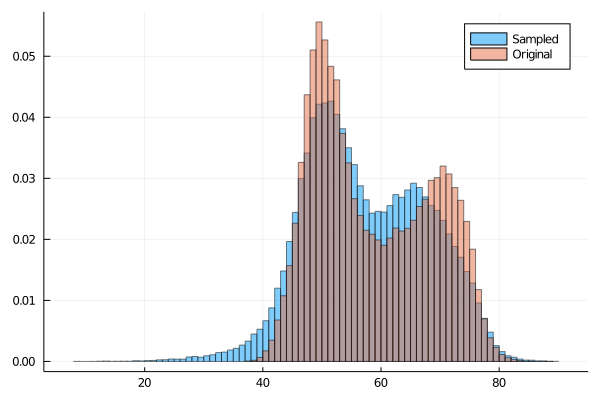

In [246]:
i = 1
histogram(sampled[:,i], alpha=.5, label="Sampled", normalize=:pdf)
histogram!(ign[:,i], alpha=.5, label="Original", normalize=:pdf)

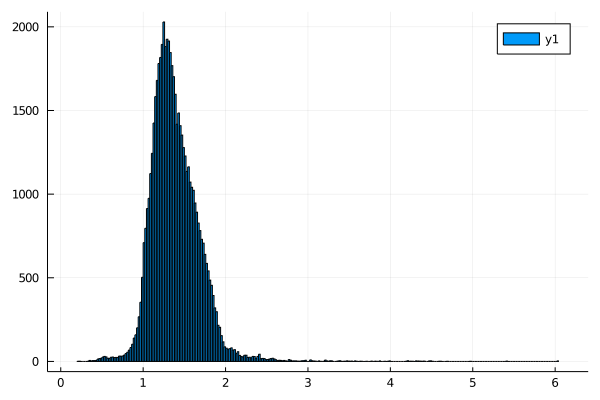

In [244]:
histogram(lr_ign[:,1])

In [208]:
ord = Array(1:10)
o = 3
ord[1:o-1] .= ord[2:o]
ord[o] = 1
ord


10-element Array{Int64,1}:
  2
  3
  1
  4
  5
  6
  7
  8
  9
 10

In [1]:
typeof(lr_ign)

LoadError: [91mUndefVarError: lr_ign not defined[39m